## PyRCA: simulation

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append('../')

In [4]:
from PyRCA.pyrca.simulation import data_gen

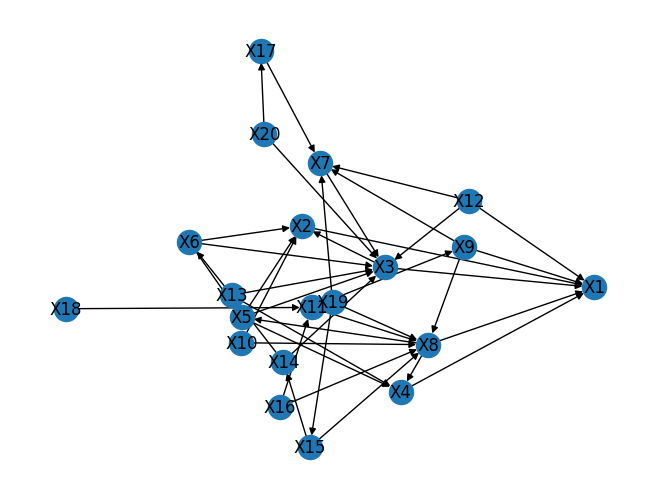

In [5]:
import networkx as nx

graph_matrix = data_gen.DAGGen(data_gen.DAGGenConfig(num_node=20, num_edge=40)).gen()
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

nx.draw(G, with_labels = True)

In [6]:
config = data_gen.DataGenConfig(dag=graph_matrix, func_type='identity', noise_type='laplace', weight_generator='normal', num_samples=160)
normal_data, parent_weights, noise_weights, func_form, noise_form = data_gen.DataGen(config).gen()

In [7]:
normal_data

array([[  3.57001022,   2.95353021,   4.4049878 , ...,   1.20676052,
         -0.42898706,   1.94953653],
       [ 27.74746548,   4.25799102,   9.83351629, ...,  -5.87334364,
          0.64394661,   1.07966607],
       [ -1.47027595, -24.16911629,  21.02280076, ...,   1.43444708,
          1.16742693,   2.6969522 ],
       ...,
       [ -7.21492283, -12.55839774,  -2.37482086, ...,  -0.85110346,
         -0.75623123,  -1.06593192],
       [  6.82560486,   4.98644989,   5.56865401, ...,  -1.35394116,
          1.2434216 ,   1.5319695 ],
       [ -2.60185449,   9.38633004, -13.29261611, ...,   0.47313202,
         -0.8052556 ,  -3.62141241]])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

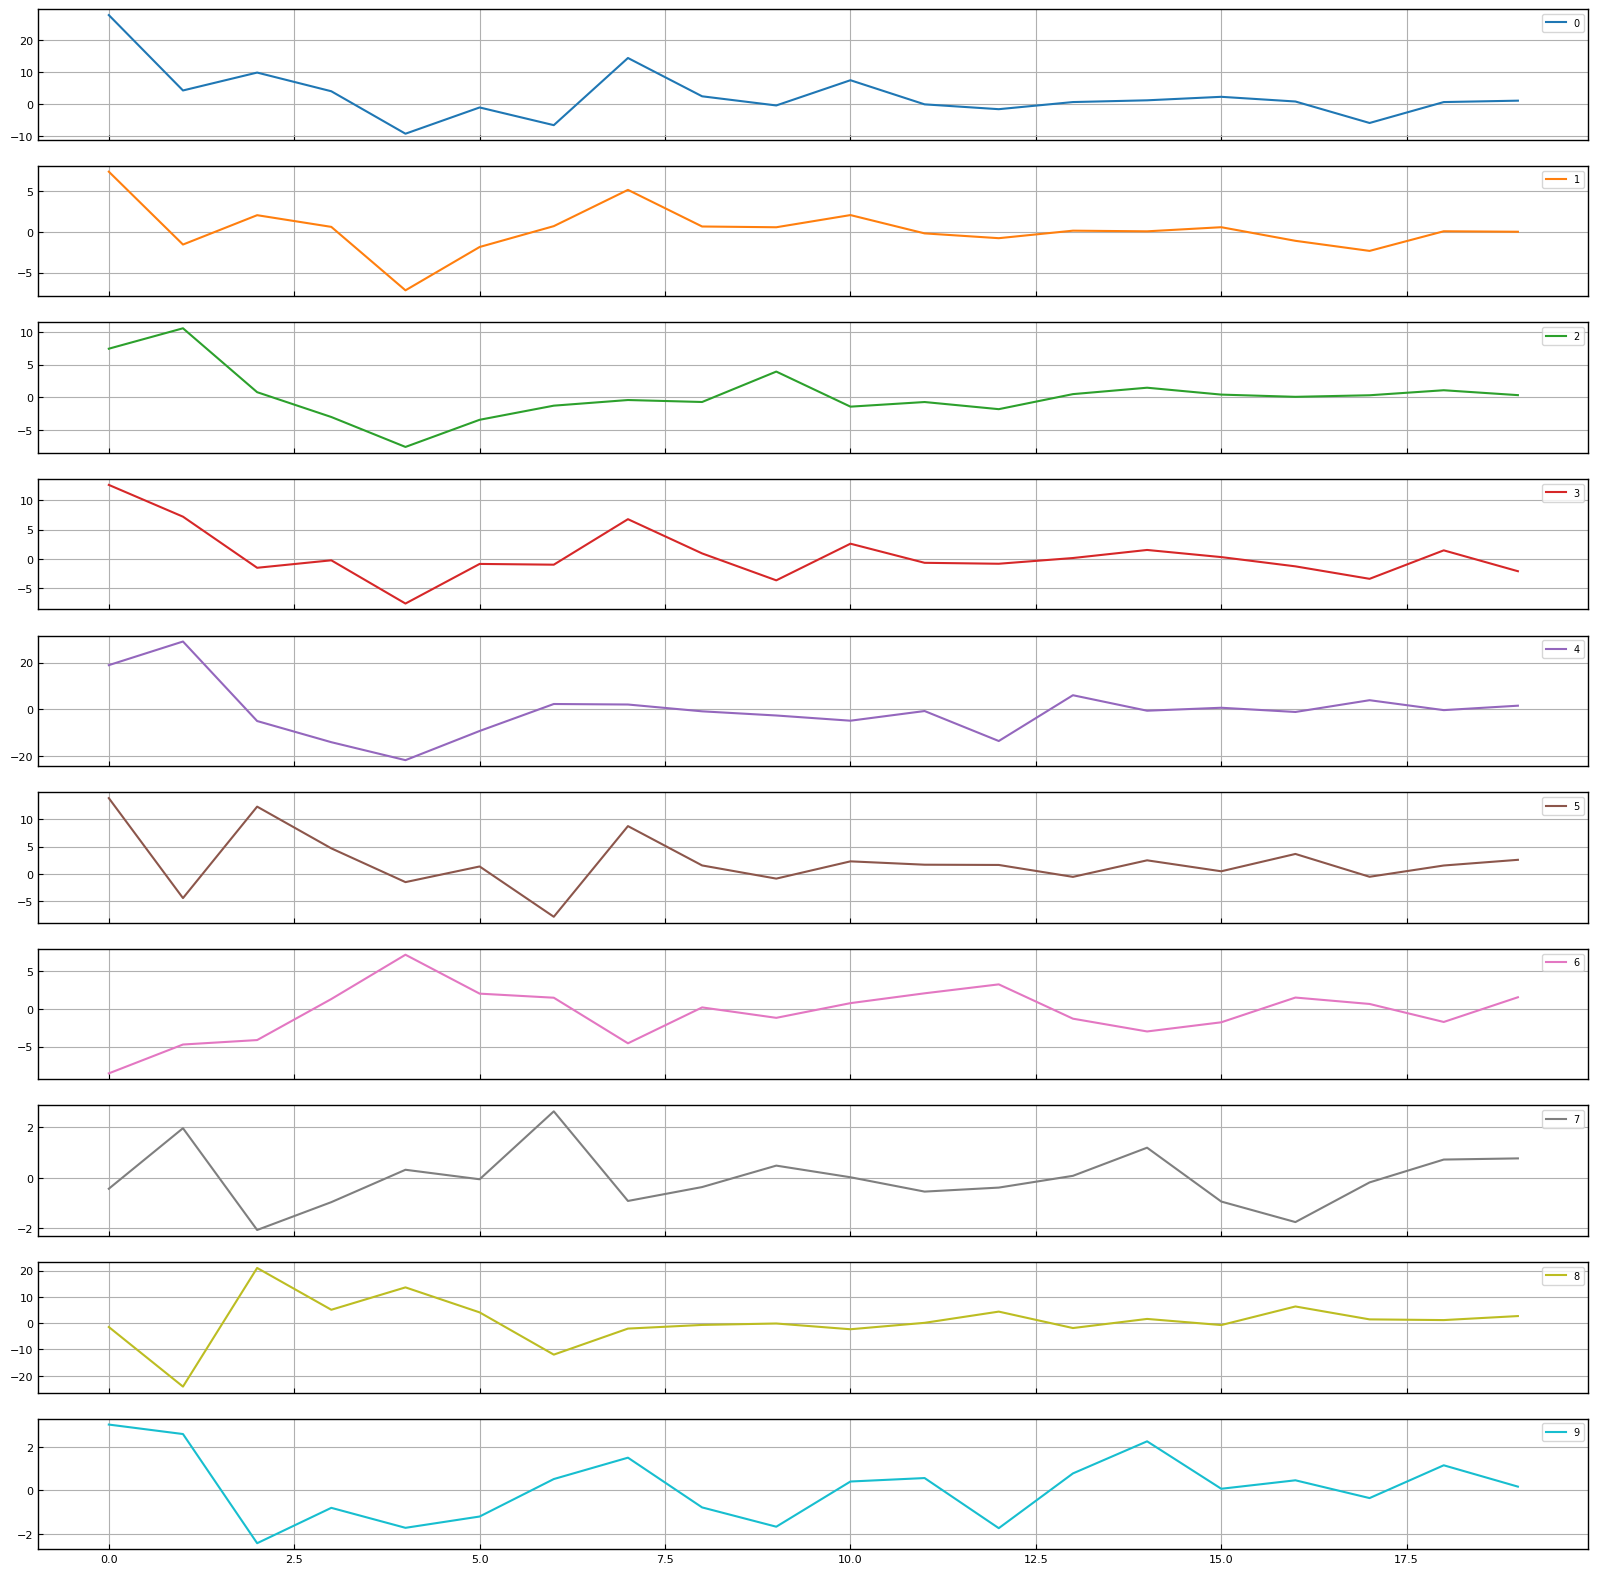

In [8]:
pd.DataFrame(normal_data[np.random.choice(normal_data.shape[1], size=10)].T).plot(subplots=True, figsize=(20, 20))

In [9]:
_SLI = 0
tau = 3
baseline = normal_data[:, _SLI].mean()
sli_sigma = normal_data[:, _SLI].std()
threshold = tau * sli_sigma

In [10]:
config = data_gen.AnomalyDataGenConfig(
    parent_weights=parent_weights, 
    noise_weights=noise_weights, 
    func_type=func_form,
    noise_type=noise_form,
    threshold=threshold,
    baseline=baseline, 
    anomaly_type=1,
    num_samples=20,
)
anomaly_data, fault = data_gen.AnomalyDataGen(config).gen()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

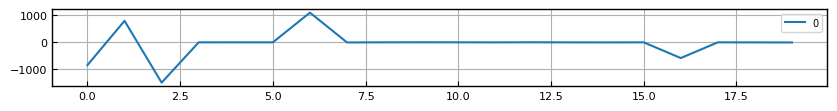

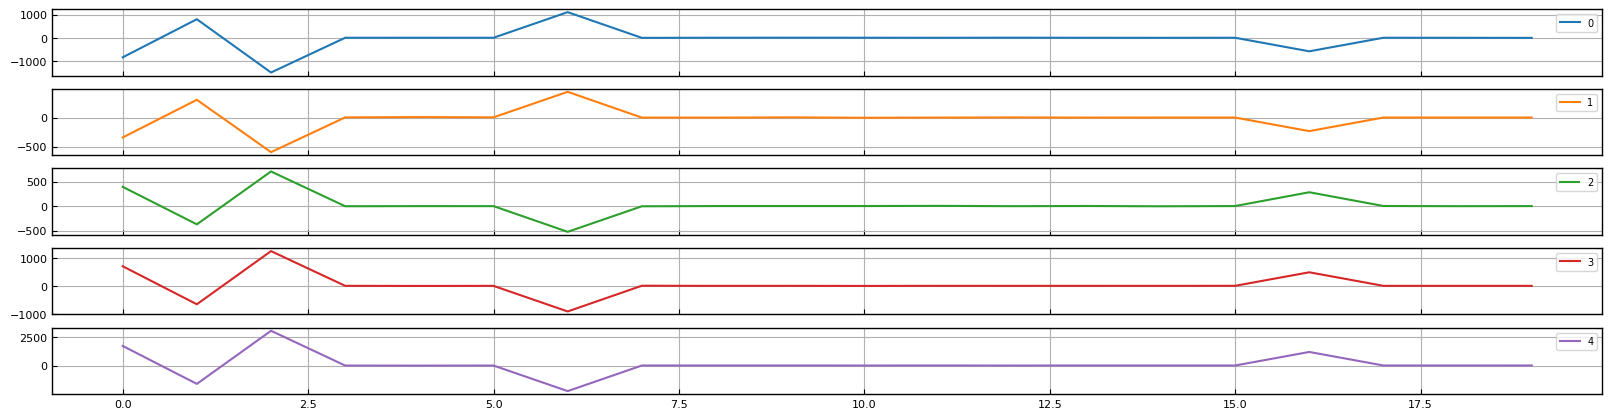

In [11]:
pd.DataFrame(anomaly_data[np.where(fault != 0)[0]].T).plot(subplots=True, figsize=(10, 1))
pd.DataFrame(anomaly_data[np.random.choice(anomaly_data.shape[1], size=5)].T).plot(subplots=True, figsize=(20, 5))

The generated graph: True is directed and acyclic.


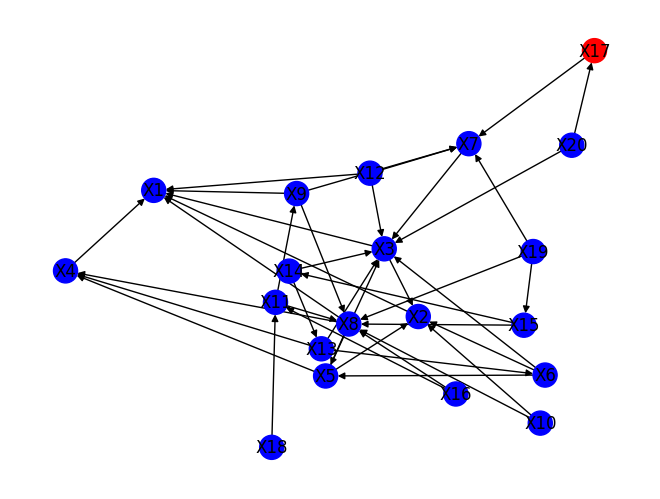

In [12]:
# constructure networkx graph from adjacent matrix
G = nx.DiGraph(graph_matrix)

# transform node names from 0 to N-1 to X1 to XN
no_of_var = graph_matrix.shape[0]
original_names = [i for i in range(no_of_var)]
node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
mapping = dict(zip(original_names, node_names))
G = nx.relabel_nodes(G, mapping)

# label the root cause nodes 
no_of_var = graph_matrix.shape[0]
color_list = np.array(['blue','red'])
node_color_idx = np.zeros(no_of_var).astype(int)
node_color_idx[fault != 0] = 1
node_color = color_list[node_color_idx]
print(f"The generated graph: {nx.is_directed_acyclic_graph(G)} is directed and acyclic.")
nx.draw(G, with_labels = True, node_color=node_color)

In [13]:
import sys
sys.path.append('../PyRCA')

In [14]:
from pyrca.graphs.causal.pc import PC
import pandas as pd

# load data
normal_data_df = pd.DataFrame(normal_data, columns=node_names)
abnormal_data_df = pd.DataFrame(anomaly_data, columns=node_names)

In [15]:
from pyrca.analyzers.ht import HT, HTConfig

# train causal graph construction model
model = PC(PC.config_class())
estimated_matrix = model.train(normal_data_df)
model = HT(config=HTConfig(graph=estimated_matrix, root_cause_top_k=10))
model.train(normal_data_df)

results = model.find_root_causes(abnormal_data_df, "X1", adjustment=True).to_list()
print(results)

  0%|          | 0/20 [00:00<?, ?it/s]

[{'root_cause': 'X20', 'score': 2421.8322635571235, 'paths': ['X20', 'X17', 'X7', 'X1']}, {'root_cause': 'X17', 'score': 2418.1818855296874, 'paths': ['X17', 'X7', 'X1']}, {'root_cause': 'X7', 'score': 920.2425651035143, 'paths': ['X7', 'X1']}, {'root_cause': 'X3', 'score': 816.3350535805762, 'paths': None}, {'root_cause': 'X12', 'score': 446.61721856923657, 'paths': None}, {'root_cause': 'X5', 'score': 436.17102187926827, 'paths': ['X5', 'X1']}, {'root_cause': 'X16', 'score': 434.81928786934725, 'paths': ['X16', 'X8', 'X1']}, {'root_cause': 'X1', 'score': 431.7004568717716, 'paths': ['X1']}, {'root_cause': 'X2', 'score': 29.754829146027856, 'paths': None}, {'root_cause': 'X4', 'score': 7.701672529167768, 'paths': None}]


In [16]:
true_root_causes = [mapping[i] for i in np.where(fault != 0)[0]]
# evaluate the results for true_root_causes
for top_k, item in enumerate(results, start=1):
    if item["root_cause"] in true_root_causes:
        print(f"Top {top_k} root cause: {item['root_cause']} is correct.")

Top 2 root cause: X17 is correct.


In [17]:
from pyrca.analyzers.rcd import RCD, RCDConfig

model = RCD(config=RCDConfig(k=10, localized=True))
results = model.find_root_causes(normal_data_df, abnormal_data_df).to_list()
print(results)

[{'root_cause': 'X7', 'score': None, 'paths': None}, {'root_cause': 'X17', 'score': None, 'paths': None}]


In [18]:
# evaluate the results for true_root_causes
for top_k, item in enumerate(results, start=1):
    if item["root_cause"] in true_root_causes:
        print(f"Top {top_k} root cause: {item['root_cause']} is correct.")

Top 2 root cause: X17 is correct.


## Massive Experiments

In [22]:
def generate_synthetic_data(
    num_node: int,
    num_edge: int,
    num_normal_samples: int,
    num_abnormal_samples: int,
    anomaly_type: int,
    func_type: str = 'identity',
    noise_type: str = 'uniform',
    weight_generator: str = 'uniform',
) -> tuple[pd.DataFrame, pd.DataFrame, list[str], pd.DataFrame, set[str]] | tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, list[str], pd.DataFrame]:
    graph_matrix = data_gen.DAGGen(
        data_gen.DAGGenConfig(num_node=num_node, num_edge=num_edge)
    ).gen()
    G = nx.DiGraph(graph_matrix)

    # transform node names from 0 to N-1 to X1 to XN
    no_of_var = graph_matrix.shape[0]
    original_names = [i for i in range(no_of_var)]
    node_names = [("X%d" % (i + 1)) for i in range(no_of_var)]
    mapping = dict(zip(original_names, node_names))
    G = nx.relabel_nodes(G, mapping)
    adjacency_df = pd.DataFrame({node_names[i]: graph_matrix[:, i] for i in range(len(node_names))}, index=node_names)

    # _VALID_NOISE = ["normal", "exponential", "uniform", "laplace"]
    # _VALID_FUNC = ["identity", "square", "sin", "tanh"]
    # _VALID_WEIGHT = ["normal", "uniform"]
    normal_data, parent_weights, noise_weights, func_form, noise_form = data_gen.DataGen(
        data_gen.DataGenConfig(
            dag=graph_matrix,
            func_type=func_type,
            noise_type=noise_type,
            weight_generator=weight_generator,
            num_samples=num_normal_samples,
        )
    ).gen()

    # --- Abnormal data ---config = data_gen.AnomalyDataGenConfig(
    _SLI = 0
    tau = 3
    baseline = normal_data[:, _SLI].mean()
    sli_sigma = normal_data[:, _SLI].std()
    threshold = tau * sli_sigma
    anomaly_data, fault = data_gen.AnomalyDataGen(
        data_gen.AnomalyDataGenConfig(
            parent_weights=parent_weights, 
            noise_weights=noise_weights, 
            func_type=func_form,
            noise_type=noise_form,
            threshold=threshold,
            baseline=baseline, 
            anomaly_type=anomaly_type,
            num_samples=num_abnormal_samples,
        )
    ).gen()
    true_root_causes = [mapping[i] for i in np.where(fault != 0)[0]]
    propagation_paths = []
    for root_cause in true_root_causes:
        paths = nx.all_simple_paths(G, source=root_cause, target=["X1"])
        propagation_paths.extend(list(paths))
    anomaly_propagated_nodes = set([node for path in propagation_paths for node in path])

    normal_data_df = pd.DataFrame(normal_data, columns=node_names)
    abnormal_data_df = pd.DataFrame(anomaly_data, columns=node_names)

    return normal_data_df, abnormal_data_df, true_root_causes, adjacency_df, anomaly_propagated_nodes


import networkx as nx
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis, EpsilonDiagnosisConfig
from pyrca.analyzers.ht import HT, HTConfig
from pyrca.analyzers.random_walk import RandomWalk, RandomWalkConfig
from pyrca.analyzers.rcd import RCD, RCDConfig
from pyrca.analyzers.bayesian import BayesianNetwork, BayesianNetworkConfig
from pyrca.graphs.causal.pc import PC, PCConfig
from pyrca.graphs.causal.lingam import LiNGAM, LiNGAMConfig


def run_rca(
    normal_data_df: pd.DataFrame,
    abnormal_data_df: pd.DataFrame,
    graph: pd.DataFrame,
    true_root_causes: list[str],
    model_name: str,
    top_k: int,
):
    hits: dict[int, int] = {}
    for k in range(1, top_k + 1):
        hits[k] = 0

    match model_name:
        case "HT":
            if "X1" not in normal_data_df.columns:
                return hits
            # estimated_matrix = PC(PCConfig(run_pdag2dag=True)).train(normal_data_df)
            model = HT(config=HTConfig(graph=graph, root_cause_top_k=top_k))
            model.train(normal_data_df)
            results = model.find_root_causes(abnormal_data_df, "X1", adjustment=True).to_list()
        case "RCD":
            model = RCD(config=RCDConfig(k=top_k, localized=True))
            results = model.find_root_causes(normal_data_df, abnormal_data_df).to_list()
        case "EpsilonDiagnosis":
            model = EpsilonDiagnosis(config=EpsilonDiagnosisConfig(root_cause_top_k=top_k))
            model.train(normal_data_df)
            results = model.find_root_causes(abnormal_data_df).to_list()
        case "RandomWalk":
            if "X1" not in normal_data_df.columns:
                return hits
            # estimated_matrix = PC(PCConfig(run_pdag2dag=True)).train(normal_data_df)
            model = RandomWalk(config=RandomWalkConfig(graph=graph, root_cause_top_k=top_k, use_partial_corr=False))
            results = model.find_root_causes(["X1"], abnormal_data_df).to_list()
        case "BayesianNetwork":
            if "X1" not in normal_data_df.columns:
                return hits
            # estimated_matrix = PC(PCConfig(run_pdag2dag=True)).train(normal_data_df)
            model = BayesianNetwork(config=BayesianNetworkConfig(graph=graph, root_cause_top_k=top_k))
            model.train([normal_data_df, abnormal_data_df])
            # results = model.find_root_causes(anomalous_metrics=model.bayesian_model.nodes).to_list()
            results = model.find_root_causes(anomalous_metrics=["X1"]).to_list()
        case "LiNGAM+PageRank":
            estimated_matrix = LiNGAM(LiNGAMConfig(run_pdag2dag=True)).train(
                pd.concat([normal_data_df, abnormal_data_df], axis=0, ignore_index=True))
            rank = nx.pagerank(nx.DiGraph(estimated_matrix).reverse())
            results = [{"root_cause": k, "score": v} for k, v in sorted(rank.items(), key=lambda item: item[1], reverse=True)][:top_k]
        case "PC+PageRank":
            estimated_matrix = PC(PCConfig(run_pdag2dag=True)).train(normal_data_df)
            rank = nx.pagerank(nx.DiGraph(estimated_matrix).reverse())
            results = [{"root_cause": k, "score": v} for k, v in sorted(rank.items(), key=lambda item: item[1], reverse=True)][:top_k]
        case _:
            raise ValueError(f"Model {model_name} is not supported.")
    
    for k in range(1, top_k + 1):
        if len(results) < k:
            continue
        if results[k-1]["root_cause"] in true_root_causes:
            hits[k] += 1
    return hits


from tsdr.multireducer import change_point_clustering_with_kde

def reduce_features(
    normal_data_df: pd.DataFrame, abnormal_data_df: pd.DataFrame, true_root_causes: list[str], graph: pd.DataFrame, anomaly_propagated_nodes: set[str],
):
    concated_data_df = pd.concat([normal_data_df, abnormal_data_df], axis=0, ignore_index=True)
    cinfo, remove_metrics = change_point_clustering_with_kde(
        concated_data_df,
        cost_model="l2",
        penalty="bic",
        n_bkps=1,
        kde_bandwidth="silverman",
        multi_change_points=True,
        representative_method=False,
        n_jobs=1,
    )
    remained_metrics = list(cinfo.keys())
    normal_data_df.drop(columns=remove_metrics, inplace=True)
    abnormal_data_df.drop(columns=remove_metrics, inplace=True)
    graph.drop(columns=remove_metrics, index=remove_metrics, inplace=True)

    root_cause_recall = len(set(remained_metrics) & set(true_root_causes)) / len(true_root_causes)
    should_interacted_nodes = anomaly_propagated_nodes & set(remained_metrics)
    recall = (len(should_interacted_nodes) / len(anomaly_propagated_nodes)) if len(anomaly_propagated_nodes) > 0 else 0.0
    precision = (len(should_interacted_nodes) / len(remained_metrics)) if len(remained_metrics) > 0 else 0.0
    if (recall + precision) == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * recall * precision / (recall + precision)
    stats = {
        "num_remained": len(remained_metrics),
        "num_total": len(concated_data_df.columns),
        "reduction_rate": len(remove_metrics) / len(concated_data_df.columns),
        "root_cause_recall": root_cause_recall,
        "recall": recall,
        "precision": precision,
        "f1_score": f1_score,
    }
    return normal_data_df, abnormal_data_df, graph, stats

In [23]:
import joblib
from threadpoolctl import threadpool_limits

# num_trials = 5
num_trials = 10
top_k = 10
models = ["RCD", "HT", "RandomWalk", "LiNGAM+PageRank", "PC+PageRank"]
# models = ["EpsilonDiagnosis"]
# anomaly_types = [0, 1, 2]
anomaly_types = [0, 1]
data_scale_params = [
    {"num_node": 50, "num_edge": 100, "num_normal_samples": 160, "num_abnormal_samples": 20},
    {"num_node": 50, "num_edge": 100, "num_normal_samples": 480, "num_abnormal_samples": 60},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 60, "num_abnormal_samples": 60},
    # {"num_node": 100, "num_edge": 500, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 500, "num_edge": 5000, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 200, "num_edge": 1000, "num_normal_samples": 480, "num_abnormal_samples": 60},
    # {"num_node": 1200, "num_edge": 6000, "num_normal_samples": 160, "num_abnormal_samples": 80},
    # {"num_node": 300, "num_edge": 600, "num_normal_samples": 160, "num_abnormal_samples": 20},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 20, "num_abnormal_samples": 20},
    # {"num_node": 50, "num_edge": 100, "num_normal_samples": 60, "num_abnormal_samples": 60},
    # {"num_node": 1200, "num_edge": 6000, "num_normal_samples": 60, "num_abnormal_samples": 60},
]


def _gen_data_and_run_rca(model: str, top_k: int, trial_no: int, anomaly_type: int, data_scale_param: dict[str, int], feature_reduction: bool = False):
    # normal_data_df, abnormal_data_df, true_root_causes, graph = generate_synthetic_data(
    #     num_node=100, num_edge=500, num_normal_samples=60, num_abnormal_samples=60, anomaly_type=anomaly_type,
    #     concat=False,
    # )
    normal_data_df, abnormal_data_df, true_root_causes, graph, anomaly_propagated_nodes = generate_synthetic_data(
        num_node=data_scale_param["num_node"],
        num_edge=data_scale_param["num_edge"],
        num_normal_samples=data_scale_param["num_normal_samples"],
        num_abnormal_samples=data_scale_param["num_abnormal_samples"],
        anomaly_type=anomaly_type,
    )
    reduction_flags = [False]
    if feature_reduction:
        reduction_flags.append(True)
    
    items = []
    for reduction_flag in reduction_flags:
        if reduction_flag:
            normal_data_df, abnormal_data_df, graph, reduction_stats = reduce_features(
                normal_data_df, abnormal_data_df, true_root_causes, graph, anomaly_propagated_nodes)
        else:
            reduction_stats = {}
        with threadpool_limits(limits=1):
            top_k_hit = run_rca(
                normal_data_df, abnormal_data_df, graph, true_root_causes, model_name=model, top_k=top_k,
            )
        assert top_k_hit, f"top_k_hit is empty for model {model}"
        for k, v in top_k_hit.items():
            items.append(
                dict(
                    {"trial_no": trial_no, "k": k, "hit": v, "num_root_causes": len(true_root_causes), "model": model, "anomaly_type": anomaly_type, "feature_reduction": reduction_flag},
                    **data_scale_param, **reduction_stats,
                )
            )
    return items

In [24]:
list_of_items = joblib.Parallel(
    n_jobs=-1, 
    backend="multiprocessing",
)(
    joblib.delayed(_gen_data_and_run_rca)(model, top_k, i, anomaly_type, data_scale_param, feature_reduction=True)
    for model in models
    for i in range(num_trials)
    for anomaly_type in anomaly_types
    for data_scale_param in data_scale_params
)
assert list_of_items is not None
results = sum(list_of_items, [])

In [25]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(results).set_index(["model", "anomaly_type", "trial_no", "num_node", "num_edge", "num_normal_samples", "num_abnormal_samples", "feature_reduction", "k"]).sort_index())

hit  \
model           anomaly_type trial_no num_node num_edge num_normal_samples num_abnormal_samples feature_reduction k         
HT              0            0        50       100      160                20                   False             1     1   
                                                                                                                  2     1   
                                                                                                                  3     0   
                                                                                                                  4     0   
                                                                                                                  5     0   
                                                                                                                  6     0   
                                                                                                                  7     1   
                                                                                                                  8     0   
                                                                                                                  9     0   
                                                                                                                  10    0   
                                                                                                True              1     1   
                                                                                                                  2     1   
                                                                                                                  3     0   
                                                                                                                  4     0   
                                                                                                                  5     0   
                                                                                                                  6     0   
                                                                                                                  7     0   
                                                                                                                  8     0   
                                                                                                                  9     1   
                                                                                                                  10    0   
                                                        480                60                   False             1     1   
                                                                                                                  2     1   
                                                                                                                  3     0   
                                                                                                                  4     0   
                                                                                                                  5     0   
                                                                                                                  6     0   
                                                                                                                  7     0   
                                                                                                                  8     0   
                                                                                                                  9     0   
                                                                                                                  10    0   
                                                                                                True              1   

In [26]:
def recall(X: pd.Series) -> pd.Series:
    k_values = list(range(1, X["k"].max()+1))
    acc_at_k = {k: .0 for k in k_values}
    num_anomalies: int = X["trial_no"].max() + 1

    for k in k_values:
        for i in range(num_anomalies):
            x = X.loc[X["trial_no"] == i]
            num_root_causes = x["num_root_causes"].max()  # assume the same for all trials
            num_hit = x.loc[x["k"] <= k]["hit"].sum()
            acc_at_k[k] += num_hit / num_root_causes

        acc_at_k[k] /= num_anomalies

    return pd.Series(acc_at_k)

pd.DataFrame(results).groupby(["model", "anomaly_type", "num_node", "num_edge", "num_normal_samples", "num_abnormal_samples", "feature_reduction"]).apply(recall)
# .apply(lambda x: recall(x["num_root_causes"].to_list(), x["hit"].to_list(), top_k))

1   \
model           anomaly_type num_node num_edge num_normal_samples num_abnormal_samples feature_reduction             
HT              0            50       100      160                20                   False              0.483333   
                                                                                       True               0.483333   
                                               480                60                   False              0.591667   
                                                                                       True               0.591667   
                1            50       100      160                20                   False              0.691667   
                                                                                       True               0.566667   
                                               480                60                   False              0.645000   
                                                                                       True               0.625000   
LiNGAM+PageRank 0            50       100      160                20                   False              0.033333   
                                                                                       True               0.633333   
                                               480                60                   False              0.000000   
                                                                                       True               0.516667   
                1            50       100      160                20                   False              0.000000   
                                                                                       True               0.350000   
                                               480                60                   False              0.000000   
                                                                                       True               0.300000   
PC+PageRank     0            50       100      160                20                   False              0.000000   
                                                                                       True               0.250000   
                                               480                60                   False              0.000000   
                                                                                       True               0.275000   
                1            50       100      160                20                   False              0.000000   
                                                                                       True               0.158333   
                                               480                60                   False              0.050000   
                                                                                       True               0.300000   
RCD             0            50       100      160                20                   False              0.000000   
                                                                                       True               0.050000   
                                               480                60                   False              0.183333   
                                                                                       True               0.150000   
                1            50       100      160                20                   False              0.033333   
                                                                                       True               0.033333   
                                               480                60                   False              0.100000   
                                                                                       True               0.158333   
RandomWalk      0            50       100      160                20                   False        

In [27]:
# _VALID_NOISE = ["normal", "exponential", "uniform", "laplace"]
# _VALID_FUNC = ["identity", "square", "sin", "tanh"]
# _VALID_WEIGHT = ["normal", "uniform"]
normal_data_df, abnormal_data_df, true_root_causes, graph, anomaly_propagated_nodes = generate_synthetic_data(
    num_node=200, num_edge=500,
    num_normal_samples=160*3, num_abnormal_samples=20*3,
    anomaly_type=1,
    func_type="identity",
    noise_type="uniform",
    weight_generator="uniform",
)

concated_data_df = pd.concat([normal_data_df, abnormal_data_df], axis=0, ignore_index=True)
cinfo, remove_metrics = change_point_clustering_with_kde(
    concated_data_df,
    cost_model="l2",
    penalty="bic",
    n_bkps=1,
    kde_bandwidth=1,
    multi_change_points=True,
    representative_method=False,
    n_jobs=1,
)

remained_metrics = list(cinfo.keys())
print(remained_metrics)
root_cause_recall = len(set(remained_metrics) & set(true_root_causes)) / len(true_root_causes)
should_interacted_nodes = anomaly_propagated_nodes & set(remained_metrics)
recall = len(should_interacted_nodes) / len(anomaly_propagated_nodes)
precision = len(should_interacted_nodes) / len(remained_metrics)
if recall == 0 or precision == 0:
    concated_data_df[remained_metrics].plot(subplots=True, figsize=(10, 1*len(remained_metrics)))
    plt.show()
elif recall > 0 or precision > 0:
    print(f"root_cause_recall: {root_cause_recall}, recall: {recall}, precision: {precision}, f1-score: {2 * recall * precision / (recall + precision)}")
print(len(remained_metrics), len(remove_metrics), len(true_root_causes), len(anomaly_propagated_nodes))
should_not_intersected_nodes = anomaly_propagated_nodes & set(remove_metrics)

concated_data_df.loc[:, "X1"].plot(figsize=(10, 1))
concated_data_df[true_root_causes].plot(subplots=True, figsize=(10, 1*len(true_root_causes)))
if len(should_not_intersected_nodes) >= 1:
    concated_data_df[should_not_intersected_nodes].plot(subplots=True, figsize=(10, 1 * len(should_not_intersected_nodes)))
# concated_data_df[anomaly_propagated_nodes].plot(subplots=True, figsize=(10, 1 * len(anomaly_propagated_nodes)))
# concated_data_df[remained_metrics].plot(subplots=True, figsize=(10, 1 * len(remained_metrics)))
# concated_data_df.sample(n=20, axis=1).plot(subplots=True, figsize=(20, 20))
# plt.show()

TypeError: generate_synthetic_data() got an unexpected keyword argument 'concat'